# Практический кейс
## «Прогнозирование размеров сварного шва при электронно-лучевой сварке тонкостенных конструкций аэрокосмического назначения»

В качестве исходных данных были взяты результаты экспериментальных
исследований, проводимых в целях улучшения технологического процесса
электронно-лучевой сварки изделия, сборка которого состоит из элементов,
состоящих из разнородного материала.
Установка электронно-лучевой сварки, на которой проводились
исследования, предназначена для сварки электронным лучом в глубоком вакууме
деталей сборочных единиц из нержавеющих сталей, титановых, алюминиевых
и специальных сплавов.
Существующая установка электронно-лучевой сварки обеспечивает
повторяемость режимов в рамках возможностей реализованной системы
управления. Работы по сварке выполнялись на образцах-имитаторах,
соответствующих технологическому изделию.
Для уменьшения вложения энергии при сварке:
1. Снижалась величина сварочного тока (IW);
2. Увеличивался ток фокусировки электронного пучка (IF);
3. Увеличивалась скорость сварки (VW);
4. Менялось расстояние от поверхности образцов до электронно-оптической
системы (FP).

По совокупности параметров технологических режимов обеспечивались
минимально возможные размеры сварных швов: глубина шва (Depth) и ширина
шва (Width).

В процессе выполнения работ была произведена электронно-лучевая сварка
18-ти единиц образцов. Результаты металлографического контроля
по размерам сварного шва для каждого образца проводились в 4-х поперечных
сечениях сварного шва. Ускоряющее напряжение было постоянным в диапазоне
19,8 – 20 кВ. Набор полученных данных собраны в составе режимов сварки,
размеров сварочных швов в поперечных сечениях всех образцов. Статистические
показатели набора обучающих данных указаны в табл. 1.

<img src="Task\Table1.png" alt="drawing" width="600"/>

## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import keras

from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Normalization
from keras.models import load_model

import pickle


## Загрузка датасета

In [2]:
raw_df = pd.read_csv("Dataset_case_1\ebw_data.csv")
raw_df.head()

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48


## Разведочный анализ

**Посмотрим общий состав и тип данных**

In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


Пропусков нет. Все параметры числовые. 
Обращает внимание малый размер выборки - всего 72 записи.

**Посмотрим описательную статистику**

In [4]:
raw_df.describe().T

,count,mean,std,min,25%,50%,75%,max
IW,72.0,45.666667,1.678363,43.00,44.00,45.50,47.00,49.00
IF,72.0,141.333333,5.145763,131.00,139.00,141.00,146.00,150.00
VW,72.0,8.638889,2.061078,4.50,8.00,9.00,10.00,12.00
FP,72.0,78.333333,21.493530,50.00,60.00,80.00,80.00,125.00
Depth,72.0,1.195556,0.225081,0.80,1.08,1.20,1.29,1.76
Width,72.0,1.970417,0.279040,1.68,1.76,1.84,2.05,2.60


Некоторые параметры имеют значительную разницу в абсолютных значениях: IF - 141.33, FP - 78.33, VW - 8.64 и так далее.

Возможно потребуется нормализация при построении моделей.

**Просмотрим совместное распределение нескольких пар столбцов из обучающего набора.**

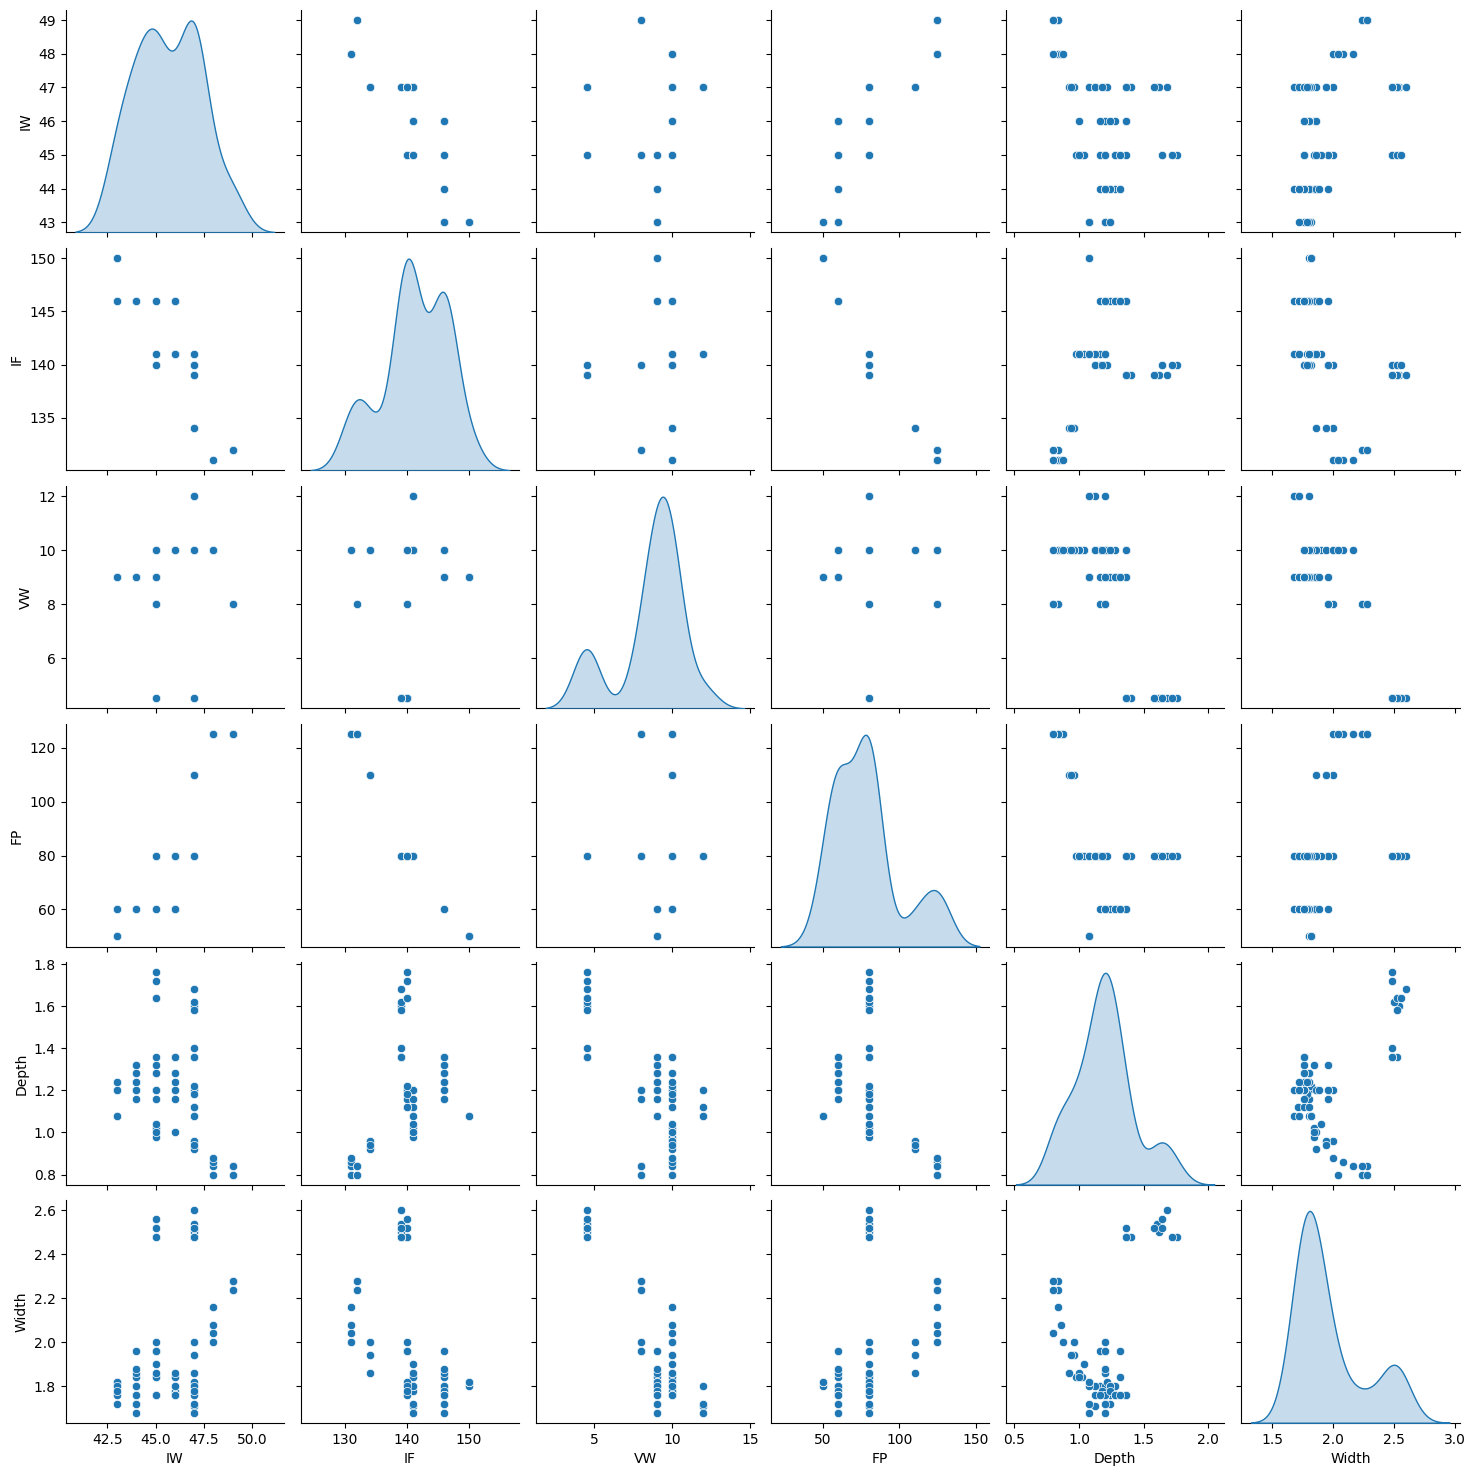

In [5]:
sns.pairplot(raw_df.astype(float), diag_kind='kde')

Параметр Скорость сварки VW имеет возможную линейную зависимость с нашей целевой переменной. По остальным параметрам такую зависимость явно не видно.

**Проверим корреляцию**

In [6]:
raw_df.corr()[['Depth','Width']]

,Depth,Width
IW,-0.289568,0.434869
IF,0.376084,-0.510167
VW,-0.671437,-0.874257
FP,-0.510748,0.412962
Depth,1.000000,0.425391
Width,0.425391,1.000000


У обоих целевых переменных видно явную корреляцию с атрибутом - Скорость сварки VW. Что в принципе подтверждалось и графиком выше. Также у глубины есть вероятная зависимость с FP - расстоянием до образца, а у ширины с IF - током фокусировки.

### Обучение моделей ML

Для начала создадим модель линейной регрессии. В дальнейшим будем сравнивать с ней качество модели нейронной сети.

In [7]:
# разделим выборку на входные переменные и целевые
X = raw_df.drop(['Depth', 'Width'], axis = 1)
y = raw_df[['Depth', 'Width']]

In [8]:
# проверим
print(X.shape)
print(y.shape)

(72, 4)
(72, 2)


Все отлично. Теперь разделим на обучающую и тестовую выборки.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
# проверим
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(61, 4)
(61, 2)
(11, 4)
(11, 2)


Замечательно, теперь соберем модель pipeline.

In [29]:
lr_pipe = Pipeline(
    [
        ('Scaler', StandardScaler()),
        ('Regression', LinearRegression())
    ])


lr_pipe.fit(X_train,y_train)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('Regression', LinearRegression())])

Посмотрим качество модели. Выведем MAE. Но так как она абсолютных величинах выведем еще в относительных от среднего значения.

In [30]:
print('MAE: ', mean_absolute_error(y_test, lr_pipe.predict(X_test)))
print('MAE of mean, %: \n', mean_absolute_error(y_test, lr_pipe.predict(X_test)) * 100 / np.mean(y_test))

MAE:  0.07807504320684869
MAE of mean, %: 
 5.278583130149572


Точность неплохая - 5%, возьмем это значение как мерило для последующих моделей.

### Разработка моделей NN

Начнем снова с разбиения выборки, но для моделей NN нам потребуется еще и валидационная выборка.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
# проверим, что мы получили
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(61, 4)
(61, 2)
(11, 4)
(11, 2)


Для удобства создадим функцию для визуализации результатов.

In [32]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Ошибка обучения')
    plt.plot(history.history['val_loss'], label='Ошибка валидации')
    plt.xlabel('Эпохи обучения')
    plt.ylabel('Ошибка прогноза')
    plt.legend()
    plt.grid(True)

**NN с одним слоем**

In [33]:
linear_model = Sequential([
    Input(shape = (X.shape[1],)),
    Dense(units=2, activation='linear', use_bias=True, bias_initializer="zeros")
])

linear_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 2)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


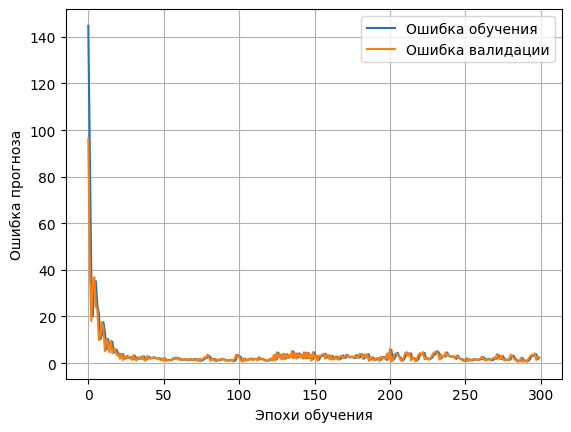

In [34]:
# скомпилируем модель
linear_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history = linear_model.fit(
    X_train,
    y_train,
    epochs=300,
    verbose=0,
    validation_split=0.3)

plot_loss(history)

In [35]:
#посмотрим последние 10 записей history
history.history['val_loss'][-10:]

[0.8293421864509583,
 0.5160039067268372,
 2.0303468704223633,
 2.91243052482605,
 3.5516357421875,
 3.3451266288757324,
 4.174407482147217,
 1.3976819515228271,
 2.695491313934326,
 2.2620766162872314]

Видно пилообразные отклонения в конце графика, возможно это связано с большим значением learning rate.
Попробуем уменьшить его.

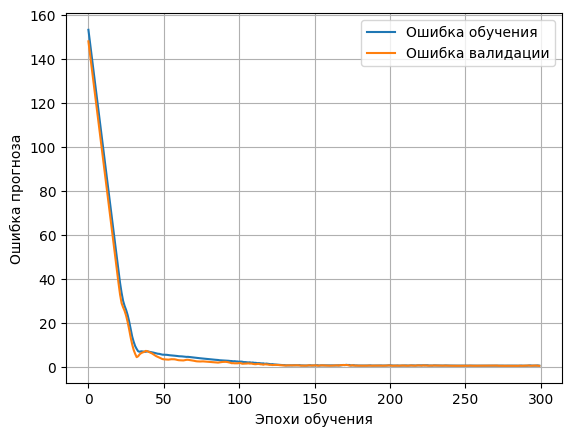

In [36]:
linear_model = Sequential([
    Input(shape = (X.shape[1],)),
    Dense(units=2, activation='linear', use_bias=True, bias_initializer="zeros")
])

linear_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss='mean_absolute_error')

history = linear_model.fit(
    X_train,
    y_train,
    epochs=300,
    verbose=0,
    validation_split=0.3)

plot_loss(history)

In [37]:
#посмотрим последние 10 записей history
history.history['val_loss'][-10:]

[0.5663406848907471,
 0.6376741528511047,
 0.6604234576225281,
 0.5366511344909668,
 0.5623824000358582,
 0.6370211243629456,
 0.6008279323577881,
 0.6650239825248718,
 0.5295140147209167,
 0.51822829246521]

In [38]:
# выведем характеристики
print('MAE: ', mean_absolute_error(y_test, linear_model.predict(X_test)))
print('MAE of mean, %: \n', mean_absolute_error(y_test, linear_model.predict(X_test)) * 100 / np.mean(y_test))

1/1 [==============================] - 0s 34ms/step
MAE:  0.48005943428386344
1/1 [==============================] - 0s 21ms/step
MAE of mean, %: 
 32.45638461661031


Такая ошибка нас не устроит, продолжим улучшать модель с коэффициентом learning rate 0.01.

**NN с двумя слоями**

Добавим слой с двойным количеством нейронов по отношению ко входу. Функцию активации выберем сигмоид.  

In [39]:
linear_model_2 = Sequential([
    Input(shape = (X.shape[1],)),
    Dense(units=128, activation='sigmoid'),
    Dense(units=2, activation='linear', use_bias=True, bias_initializer="zeros")
])

linear_model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               640       
                                                                 
 dense_7 (Dense)             (None, 2)                 258       
                                                                 
Total params: 898
Trainable params: 898
Non-trainable params: 0
_________________________________________________________________


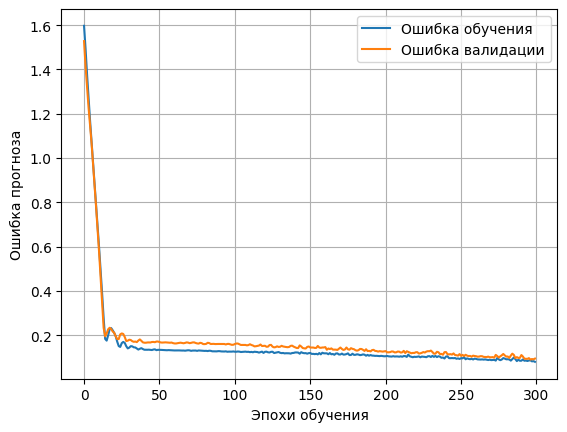

In [40]:
linear_model_2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error')

history_2 = linear_model_2.fit(
    X_train,
    y_train,
    epochs=300,
    verbose=0,
    validation_split=0.3)

plot_loss(history_2)

In [41]:
#посмотрим последние 10 записей history
history_2.history['val_loss'][-10:]

[0.11051785200834274,
 0.103730209171772,
 0.0939306691288948,
 0.09371799230575562,
 0.09326702356338501,
 0.09648630023002625,
 0.09008985757827759,
 0.09238727390766144,
 0.09105535596609116,
 0.0944817066192627]

In [42]:
# выведем характеристики
print('MAE: ', mean_absolute_error(y_test, linear_model_2.predict(X_test)))
print('MAE of mean, %: \n', mean_absolute_error(y_test, linear_model_2.predict(X_test)) * 100 / np.mean(y_test))

1/1 [==============================] - 0s 40ms/step
MAE:  0.06396413954821498
1/1 [==============================] - 0s 40ms/step
MAE of mean, %: 
 4.3245576830385035


Уже гораздо лучше, посмотрим дальше. 

**NN c тремя слоями**

In [43]:
linear_model_3 = Sequential([
    Input(shape = (X.shape[1],)),
    Dense(units=128, activation='relu'),
    Dense(units=128, activation='sigmoid'),
    Dense(units=2, activation='linear', use_bias=True, bias_initializer="zeros")
])

linear_model_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               640       
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 2)                 258       
                                                                 
Total params: 17,410
Trainable params: 17,410
Non-trainable params: 0
_________________________________________________________________


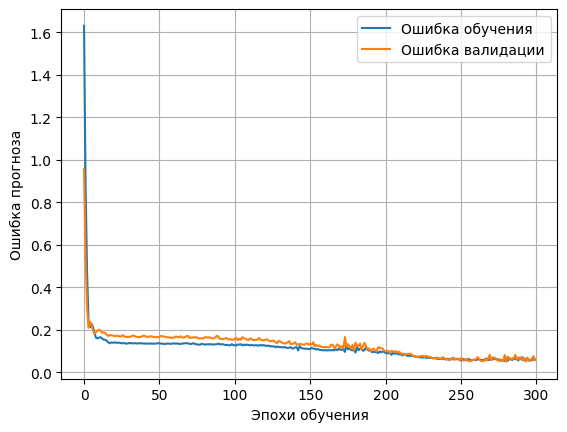

In [44]:
linear_model_3.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error')

history = linear_model_3.fit(
    X_train,
    y_train,
    epochs=300,
    verbose=0,
    validation_split=0.3)

plot_loss(history)

In [45]:
#посмотрим последние 10 записей history
history.history['val_loss'][-10:]

[0.0716470405459404,
 0.05549275875091553,
 0.0641608014702797,
 0.05072161555290222,
 0.06908128410577774,
 0.05288536846637726,
 0.05664791539311409,
 0.0648256316781044,
 0.0754626989364624,
 0.056362103670835495]

In [46]:
print('MAE: ', mean_absolute_error(y_test, linear_model_3.predict(X_test)))
print('MAE of mean, %: \n', mean_absolute_error(y_test, linear_model_3.predict(X_test)) * 100 / np.mean(y_test))

1/1 [==============================] - 0s 48ms/step
MAE:  0.059426752870733096
1/1 [==============================] - 0s 21ms/step
MAE of mean, %: 
 4.017789069318155


Получается, что модель с двумя слоями справляется лучше. Попробуем добавить слой нормализации.

In [47]:
linear_model_2_norm = Sequential([
    Input(shape = (X.shape[1],)),
    Normalization(),
    Dense(units=128, activation='sigmoid'),
    Dense(units=2, activation='linear', use_bias=True, bias_initializer="zeros")
])

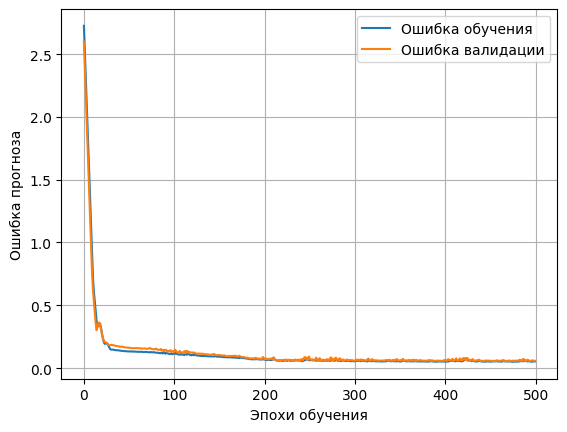

In [48]:
linear_model_2_norm.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error')

history = linear_model_2_norm.fit(
    X_train,
    y_train,
    epochs=500,
    verbose=0,
    validation_split=0.3)

plot_loss(history)

In [49]:
#посмотрим последние 10 записей history
history.history['val_loss'][-10:]

[0.05609896406531334,
 0.0655953511595726,
 0.06286206096410751,
 0.058024097234010696,
 0.05683160573244095,
 0.05735660344362259,
 0.06128378212451935,
 0.060285478830337524,
 0.05697370693087578,
 0.05772752687335014]

In [50]:
print('MAE: ', mean_absolute_error(y_test, linear_model_2_norm.predict(X_test)))
print('MAE of mean, %: \n', mean_absolute_error(y_test, linear_model_2_norm.predict(X_test)) * 100 / np.mean(y_test))

1/1 [==============================] - 0s 56ms/step
MAE:  0.03960897824980996
1/1 [==============================] - 0s 18ms/step
MAE of mean, %: 
 2.677927232623906


Такая точность вполне хорошая, переходим к сохранению модели.

### Сохранение модели

In [51]:
linear_model_2_norm.save('lr_model.keras')